In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [28]:
df = pd.read_csv("titanic.csv")
missing_values = df.isnull().sum()


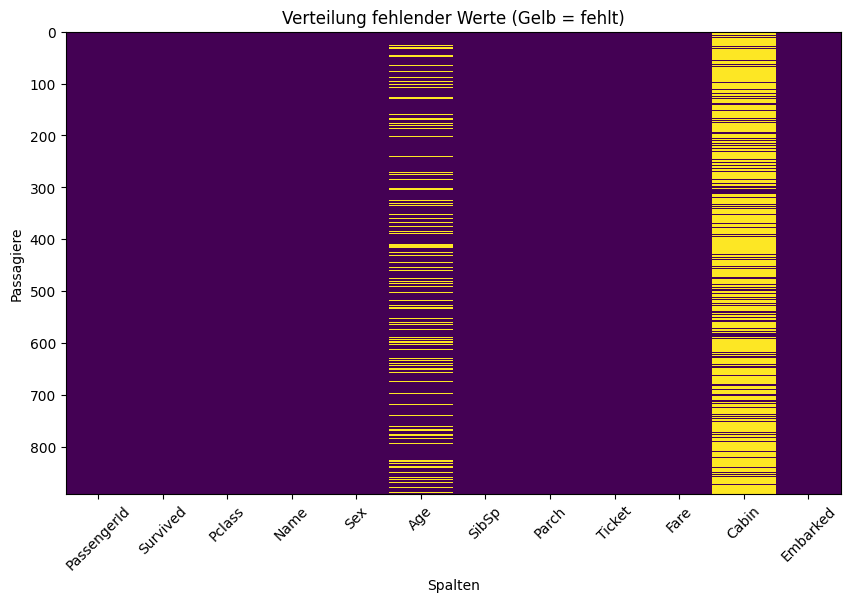

In [26]:
plt.figure(figsize=(10, 6))
plt.imshow(df.isnull(), aspect='auto', cmap='viridis', interpolation='nearest')
plt.xticks(ticks=range(len(df.columns)), labels=df.columns, rotation=45)
plt.title("Verteilung fehlender Werte (Gelb = fehlt)")
plt.xlabel("Spalten")
plt.ylabel("Passagiere")
plt.show()

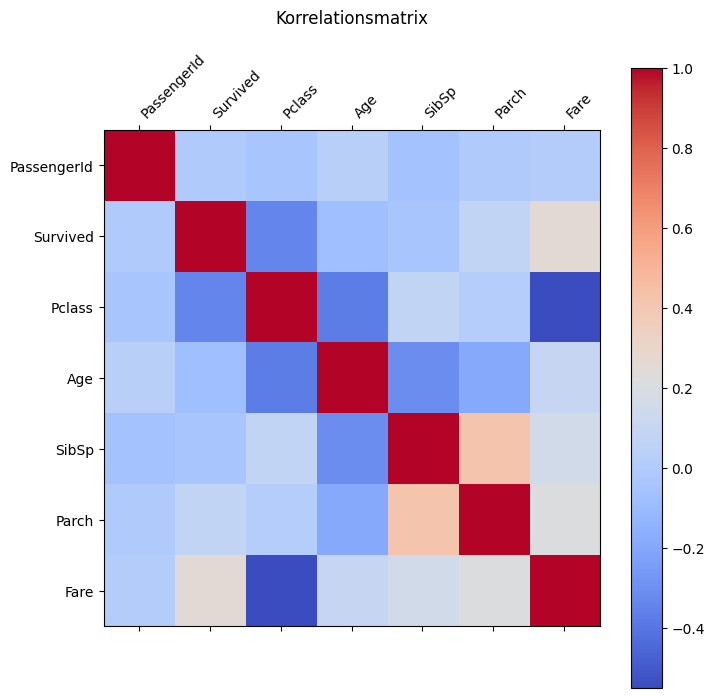

In [42]:
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

plt.figure(figsize=(8, 8))
plt.matshow(corr_matrix, fignum=1, cmap='coolwarm')
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45, ha='left')
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title("Korrelationsmatrix", pad=20)
plt.show()

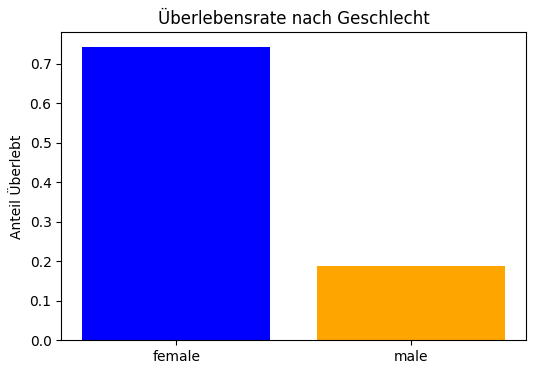

In [8]:
sex_survival = df.groupby('Sex')['Survived'].mean()

plt.figure(figsize=(6, 4))
plt.bar(sex_survival.index, sex_survival.values, color=['blue', 'orange'])
plt.title('Überlebensrate nach Geschlecht')
plt.ylabel('Anteil Überlebt')
plt.show()

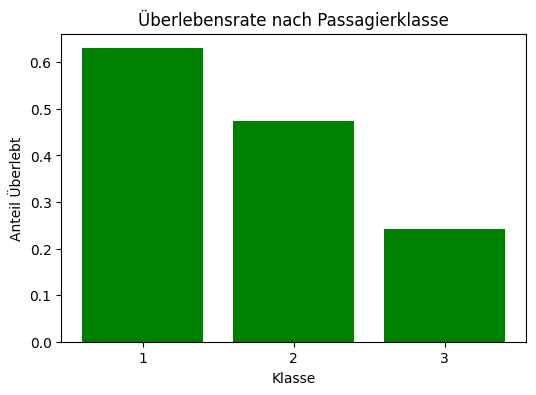

In [9]:
pclass_survival = df.groupby('Pclass')['Survived'].mean()

plt.figure(figsize=(6, 4))
plt.bar(pclass_survival.index.astype(str), pclass_survival.values, color='green')
plt.title('Überlebensrate nach Passagierklasse')
plt.xlabel('Klasse')
plt.ylabel('Anteil Überlebt')
plt.show()

In [10]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef, classification_report, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import randint

In [ ]:
X = df.drop(['Survived', 'Cabin', 'Name', 'Ticket', 'PassengerId'], axis=1)
# survived lassen wir raus, da das Programm nicht predicted, wenn es die Lösung schon kennt
# cabin hat sehr viele fehlende Werte, deßhalb ist es sinnvoll diese daten auch nicht einzubeziehen
# Name und Ticketliefern Strings mit welchen ein mathematisches Modell nichts anfangen kann
# PassengerID ist nur eine aufsteigende Zahl und daher keine brauchbare Information
y = df['Survived']
# in y werden die 'Lösungen' abgespeichert, mit welchen am Ende das Ergebnis verglichen wird

In [ ]:
numeric_features = ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass']
non_numerical_features = ['Sex', 'Embarked']
# hier wird unter numerischen Informationen und nicht numerischen Informationen unterschieden

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
# hier werden leere FElder aufgefüllt und die einzelnen kategorien aneinander angepasst

In [ ]:
non_numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
# hier werden leere Felder aufgefüllt und nicht numerische daten in numerische umgewandelt

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, numeric_features),
        ('non-numerical', non_numerical_transformer, non_numerical_features)
    ])
#hier werden die vorher getrennten Informationen zusammengeführt

In [ ]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(random_state=42))])
# in clf werden die zusammengeführten Daten durch den Algorythmus gejagt, welcher die Entscheidungen trifft

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
param_dist = {
    'classifier__n_estimators': randint(50, 200),
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': randint(2, 10)
    # hier werden die parameter für die Bäume festgelegt
}

In [ ]:
search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=10, cv=3, random_state=42, n_jobs=-1)
search.fit(X_train, y_train)

best_model = search.best_estimator_
# hier wird das beste Modell ausgewählt

In [ ]:
y_pred = best_model.predict(X_test)
mcc = matthews_corrcoef(y_test, y_pred)

print(f"MCC: {mcc:.4f}")
print("\nReport:\n", classification_report(y_test, y_pred))
# hier werden die die Vorhersagen gemacht und ausgewertet

MCC: 0.6519

Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86       105
           1       0.84      0.73      0.78        74

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



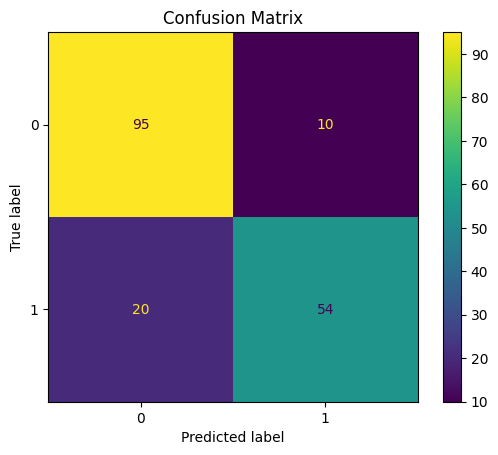

In [20]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix")
plt.show()